In [27]:
# ⚙️ 必要ライブラリ
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from types import SimpleNamespace
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import ot
from ot.unbalanced import sinkhorn_unbalanced
import os

In [28]:
# ── フォント設定（日本語ラベル用）──────────────────────────────
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
if os.path.exists(font_path):
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams["font.family"] = font_prop.get_name()
else:
    font_prop = None

# ========= notebook parameters =========
args = SimpleNamespace(
    curr         = "../../data/shared/embeddings.npy",   # 既存サービスの埋め込み (n_services × D)
    fut          = "../VAE/emb_new.npy",      # 新規サンプルの埋め込み   (N_new × D)
    # segm         = "../../data/shared/user_segments.csv",# 市場セグメント（学生/高齢者など）
    mass_curr    = None,
    plot_detail  = True,
    sensitivity_analysis = True,   # 感度分析ON/OFF
)

In [29]:
# ──────────────────────────────────────────────
# 1. 埋め込みロード & 標準化
# ──────────────────────────────────────────────
X_curr = np.load(args.curr)
Y_fut  = np.load(args.fut)

scaler = StandardScaler()
X_curr = scaler.fit_transform(X_curr)
Y_fut  = scaler.transform(Y_fut)

In [38]:
# ──────────────────────────────────────────────
# 2. 質量ベクトルの構造：既存サービス＋非ユーザー＋残留ノード
#    + 市場セグメント対応
# ──────────────────────────────────────────────
xls      = pd.ExcelFile("../../data/定額制動画配信.xlsx")
df_raw   = pd.read_excel(xls, sheet_name="data")
format_df= pd.read_excel(xls, sheet_name="Format")

sq6_1 = format_df[format_df["Question"].astype(str).str.startswith("SQ6_1[")][["Question","Title"]].dropna()
code_title = {
    int(q.split("[")[1].split("]")[0]): title
    for q, title in zip(sq6_1["Question"], sq6_1["Title"])
}
title_code = {v:k for k,v in code_title.items()}

counts = df_raw["SQ6_2"].value_counts().sort_index()
shares = counts / counts.sum()

import pickle
feat_df = pd.read_pickle("../../data/shared/feat_df.pkl")
mass_curr = []
for svc in feat_df.index:
    code = title_code.get(svc)
    mass_curr.append(shares.get(code, 0.0))
mass_curr = np.array(mass_curr, dtype=float)
service_names = feat_df.index.tolist()

# 非ユーザーの質量を市場調査や外部統計から決める
# ここでは例としてセグメント別の未利用率を仮定
# segment_df = pd.read_csv("../../data/shared/user_segments.csv")  # 例：学生,社会人,高齢者ごとの人口比と未利用率
# seg_population = segment_df["population"].values
# seg_nonuser_rate = segment_df["nonuser_rate"].values

# ── 1) 非利用率 (% ➔ 0-1) ───────────────────────
#70歳以上の高齢者層の非利用率は仮定の数値
nonuser_rate = {
    "10s":0.036,"20s":0.005,"30s":0.012,"40s":0.035,
    "50s":0.072,"60s":0.211,"70s":0.298,"80s":0.374,"90s":0.486
}
population_thousand = {
    "10s":5185+5457, "20s":6260+6519, "30s":6395+6871, "40s":7631+8745,
    "50s":9788+8490, "60s":7571+7268, "70s":8198+7886, "80s":6138+3944,
    "90s":2088+635   # 90 歳以上
}

# 実人数に変換（×1_000）
population = {k: v * 1_000 for k, v in population_thousand.items()}

# ── 3) DataFrame を列方向で作る  ──────────────────
import pandas as pd

df = pd.DataFrame({
    "population": pd.Series(population, dtype=float),
    "nonuser_rate": pd.Series(nonuser_rate, dtype=float)
})

# ── 4) 加重平均で全国非ユーザー率を算出 ──────────
nonuser_mass = (df["population"] * df["nonuser_rate"]).sum() / df["population"].sum()
print(f"全国 OTT 非ユーザー率 = {nonuser_mass:.2%}")   # 例：6.47 %

# ── 5) OT 用の質量ベクトルに組み込む ─────────────
# 2) ── 質量ベクトル（重複なく１本で） -----------------
residual_mass = 0.138 # 残留層の質量（例：13.8%）
a = np.append(mass_curr, [nonuser_mass, residual_mass])
a = np.maximum(a, 1e-12);  a /= a.sum()           # 正規化
all_source_names = service_names + ["(非ユーザー)","(残留層)"]

n = X_curr.shape[0]
m = Y_fut.shape[0]

# 複数ARPU、サービスごとの単価も考慮（例）
# arpu_list = np.loadtxt("../../data/shared/arpu.csv")  # 新サービスごとのARPU仮定（円）

# arpu.csv をまだ作成していない場合、仮データで進める
# 仮の ARPU データ
arpu_list = np.array([1200, 1500, 1000, 1300, 1600])  # サービスごとの月額単価（仮）

# セグメント別分析（学生・社会人・高齢者…）のループにも対応可能

# 複数距離（コサイン×α＋価格差×β＋ブランド差×γ）で複合コスト
def composite_distance(X, Y, cosine_w=0.6, price_w=0.3, brand_w=0.1):
    # 仮：price_diff, brand_diffはデータがあれば計算
    D_cos = pairwise_distances(X, Y, metric="cosine")
    D_price = np.zeros_like(D_cos)  # 価格差が無い場合は0
    D_brand = np.zeros_like(D_cos)
    return (cosine_w * D_cos + price_w * D_price + brand_w * D_brand)

# ---------------- 外部アンケート -----------------
# バリア別シェア (%)  × 重み  を足し合わせて raw スコアを作る
barrier_share  = {"no_intent":0.437, "few_titles":0.278,
                  "procedure":0.12,  "price":0.10}
barrier_weight = {"no_intent":1.0,   "few_titles":0.7,
                  "procedure":0.5,   "price":0.5}

D_nonuser_base = sum(barrier_share[k]*barrier_weight[k] for k in barrier_share)   # ≒0.46
median_d = np.median(pairwise_distances(X_curr, metric="cosine"))  # ≒0.40
D_nonuser_norm = D_nonuser_base / median_d                         # ≒1.15


# パラメータ感度分析用の設定
param_grid = {
    "nonuser_mass"   : [nonuser_mass*0.7, nonuser_mass, nonuser_mass*1.3],
    "D_factor"       : [0.8, 1.0, 1.2],              # 🔴 倍率で回す
    "residual_mass"  : [0.10, 0.14, 0.18],
    "eps"            : [0.1, 0.2, 0.3],
    "tau"            : [0.05, 0.1, 0.2]
}


#市場規模
# すでにある df には
#   df["population"]   … 年代別人口（人）
#   df["nonuser_rate"] … 非利用率（0–1）
# が入っている

# ── 年代別「利用者数」を追加 ─────────────────────
df["user_count"] = df["population"] * (1 - df["nonuser_rate"])

# ── 全体市場ユーザー数を算出 ────────────────────
total_market_size = int(df["user_count"].sum())

print(df)                           # 中身を確認したい場合
print(f"▶ total_market_size = {total_market_size:,} 人")

total_market_size = int(df["user_count"].sum())

全国 OTT 非ユーザー率 = 13.48%
     population  nonuser_rate  user_count
10s  10642000.0         0.036  10258888.0
20s  12779000.0         0.005  12715105.0
30s  13266000.0         0.012  13106808.0
40s  16376000.0         0.035  15802840.0
50s  18278000.0         0.072  16961984.0
60s  14839000.0         0.211  11707971.0
70s  16084000.0         0.298  11290968.0
80s  10082000.0         0.374   6311332.0
90s   2723000.0         0.486   1399622.0
▶ total_market_size = 99,555,518 人


In [39]:



# =============================================================
# 3. 新サービス候補1つずつに対してOTを実施 + パラメータ感度分析
# =============================================================

def run_ot_for_candidate(idx, nonuser_mass, D_factor, residual_mass, eps, tau):
    # 新サービスベクトル
    Y_single = Y_fut[idx].reshape(1, -1)
    # composite distance
    D_existing = composite_distance(X_curr, Y_single, cosine_w=0.7, price_w=0.2, brand_w=0.1)  # (n,1)
    # 非ユーザーと残留層から新サービスへのコスト（現実的ならセグメント別に分けて実装）
    D_nonuser_arr = np.array([[D_nonuser_norm * D_factor]])
    D_resid_arr   = np.array([[2.0]])   # 残留層は「絶対動かない」ので大きめコスト
    D = np.vstack([D_existing, D_nonuser_arr, D_resid_arr])  # (n+2, 1)
    D = D / np.median(D)

    # 質量ベクトル
    a_vec = np.append(np.maximum(mass_curr, 1e-12), [nonuser_mass, residual_mass])
    a_vec /= a_vec.sum()

    b = np.array([1.0])  # 1サービスだけに1

    # OT計算
    T = sinkhorn_unbalanced(a_vec, b, D, reg=eps, reg_m=tau)
    inbound_total  = T.sum()
    inbound_users  = inbound_total * total_market_size

    from_existing  = T[:-2, 0].sum()
    from_nonuser   = T[-2, 0]
    from_residual  = T[-1, 0]
    bo_ratio = from_nonuser / inbound_total if inbound_total > 0 else 0
    residual_ratio = from_residual / inbound_total if inbound_total > 0 else 0

    # Novelty
    novelty = D_existing.min()

    # ブルーオーシャンスコア
    blue_score = from_nonuser * novelty

    # 売上予測（単価は候補ごとに可変）
    try:
        arpu = arpu_list[idx]
    except:
        arpu = 1200
    estimated_sales = inbound_users * arpu

    return {
        "service": f"new{idx}",
        "from_existing": from_existing * total_market_size,
        "from_nonuser": from_nonuser * total_market_size,
        "from_residual": from_residual * total_market_size,
        "residual_ratio": residual_ratio,
        "total_inflow": inbound_users,
        "nonuser_ratio": bo_ratio,
        "novelty": novelty,
        "BlueOceanScore": blue_score,
        "estimated_sales": estimated_sales,
        "arpu": arpu,
        "eps": eps,
        "tau": tau,
        "nonuser_mass": nonuser_mass,
        "D_nonuser": float(D_nonuser_arr),
        "residual_mass": residual_mass
    }

# グリッドサーチ・感度分析
if args.sensitivity_analysis:
    from itertools import product
    results = []
    for nonuser_mass, D_factor, residual_mass, eps, tau in product(
            param_grid["nonuser_mass"], param_grid["D_factor"],
            param_grid["residual_mass"], param_grid["eps"], param_grid["tau"]):
        print(f"Running for: nonuser={nonuser_mass:.2f}, D_nonuser={D_factor:.2f}, residual={residual_mass:.2f}, eps={eps:.2f}, tau={tau:.2f}")
        for idx in range(m):
            res = run_ot_for_candidate(idx, nonuser_mass, D_factor, residual_mass, eps, tau)
            results.append(res)
    df_result = pd.DataFrame(results)
    df_result.to_csv("results/scores_sensitivity.csv", index=False)
    # ここで最大値・安定性・パラメータ感度を多軸で分析
    # 例えば pivot_table やヒートマップで
else:
    # 1パターンだけ
    results = []
    for idx in range(m):
        res = run_ot_for_candidate(
            idx, nonuser_mass, D_nonuser=1.0, residual_mass=residual_mass,
            eps=0.2, tau=0.1)
        results.append(res)
    df_result = pd.DataFrame(results)
    df_result.to_csv("results/scores.csv", index=False)

Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.09, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.13, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.20, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.10, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=0.80, residual=0.18, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.20, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.10, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.00, residual=0.18, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.05


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.10, eps=0.30, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.20, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.10


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.20, residual=0.14, eps=0.30, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.10, tau=0.20
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.20, tau=0.20


/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "D_nonuser": float(D_nonuser_arr),
/tmp/ipykernel_2511/3779976706.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is de

Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.05
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.10
Running for: nonuser=0.18, D_nonuser=1.20, residual=0.18, eps=0.30, tau=0.20


=== Blue-Ocean Score TOP10 ===


,service,from_existing,from_nonuser,from_residual,residual_ratio,total_inflow,nonuser_ratio,novelty,BlueOceanScore,estimated_sales,arpu,eps,tau,nonuser_mass,D_nonuser,residual_mass
3418,new18,1.480762e+07,5.145192e+06,45063.937089,0.002253,1.999787e+07,0.257287,0.530790,0.027432,2.399745e+10,1200,0.3,0.2,0.175265,0.558967,0.10
3598,new18,1.448081e+07,5.031636e+06,61697.104384,0.003152,1.957414e+07,0.257055,0.530790,0.026827,2.348897e+10,1200,0.3,0.2,0.175265,0.558967,0.14
3400,new0,2.011743e+07,4.829484e+06,45213.846379,0.001809,2.499212e+07,0.193240,0.547681,0.026568,2.999055e+10,1200,0.3,0.2,0.175265,0.558967,0.10
3417,new17,1.626103e+07,5.165733e+06,49198.938305,0.002291,2.147596e+07,0.240536,0.507734,0.026345,2.577115e+10,1200,0.3,0.2,0.175265,0.558967,0.10
3778,new18,1.417058e+07,4.923841e+06,77625.428717,0.004049,1.917204e+07,0.256824,0.530790,0.026252,2.300645e+10,1200,0.3,0.2,0.175265,0.558967,0.18
3580,new0,1.967442e+07,4.723135e+06,61905.486262,0.002531,2.445947e+07,0.193101,0.547681,0.025983,2.935136e+10,1200,0.3,0.2,0.175265,0.558967,0.14
3597,new17,1.590207e+07,5.051702e+06,67358.052785,0.003204,2.102113e+07,0.240315,0.507734,0.025764,2.522536e+10,1200,0.3,0.2,0.175265,0.558967,0.14
3760,new0,1.925390e+07,4.622183e+06,77891.553988,0.003252,2.395398e+07,0.192961,0.547681,0.025428,2.874477e+10,1200,0.3,0.2,0.175265,0.558967,0.18
3777,new17,1.556133e+07,4.943455e+06,84747.500888,0.004116,2.058953e+07,0.240096,0.507734,0.025212,2.470744e+10,1200,0.3,0.2,0.175265,0.558967,0.18
3358,new18,1.119994e+07,4.539577e+06,13995.016251,0.000888,1.575351e+07,0.288163,0.530790,0.024203,1.890421e+10,1200,0.2,0.2,0.175265,0.558967,0.10


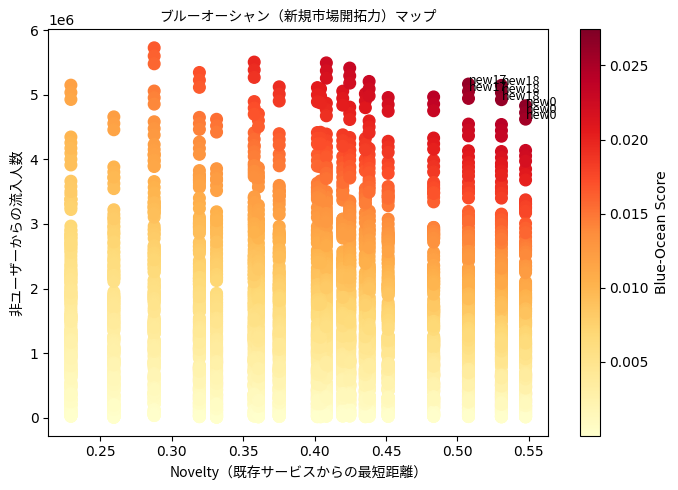

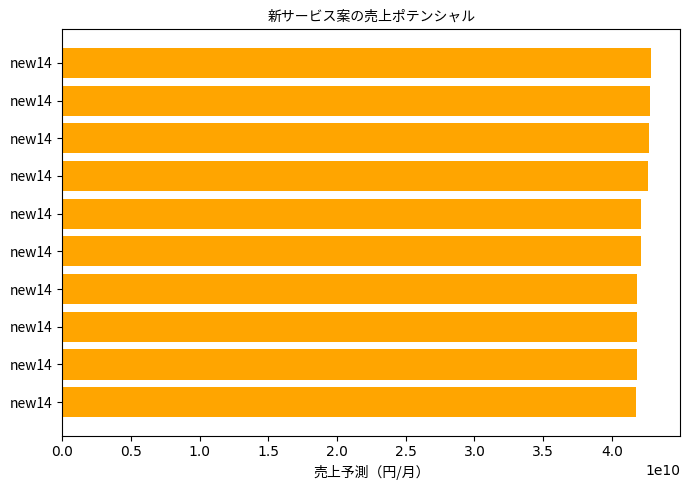

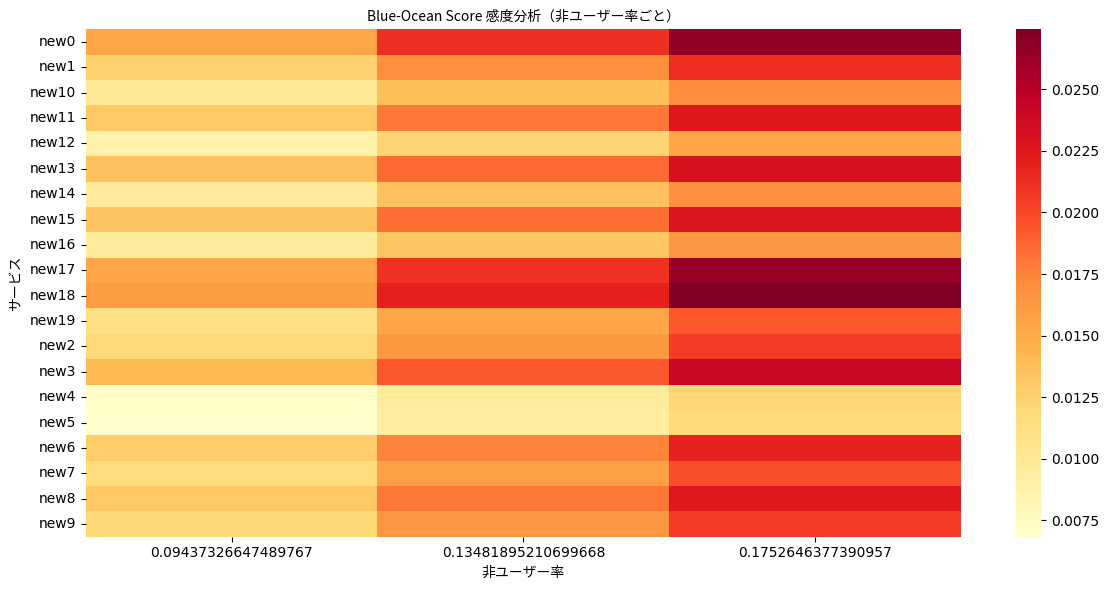

In [40]:
# =============================================================
# 4. 可視化・ランキング出力
# =============================================================

print("=== Blue-Ocean Score TOP10 ===")
display(df_result.sort_values("BlueOceanScore", ascending=False).head(10))

plt.figure(figsize=(7,5))
plt.scatter(df_result["novelty"], df_result["from_nonuser"], 
            c=df_result["BlueOceanScore"], cmap="YlOrRd", s=70)
plt.colorbar(label="Blue-Ocean Score")
for _, row in df_result.sort_values("BlueOceanScore", ascending=False).head(8).iterrows():
    plt.text(row.novelty, row.from_nonuser, row.service, fontsize=9,
             fontproperties=font_prop)
plt.xlabel("Novelty（既存サービスからの最短距離）", fontproperties=font_prop)
plt.ylabel("非ユーザーからの流入人数", fontproperties=font_prop)
plt.title("ブルーオーシャン（新規市場開拓力）マップ", fontproperties=font_prop)
plt.tight_layout()
plt.show()

# 売上予測上位
plt.figure(figsize=(7,5))
order = np.argsort(df_result["estimated_sales"])[::-1][:10]
plt.barh(range(10), df_result.iloc[order]["estimated_sales"], color="orange")
plt.yticks(range(10), df_result.iloc[order]["service"], fontproperties=font_prop)
plt.xlabel("売上予測（円/月）", fontproperties=font_prop)
plt.title("新サービス案の売上ポテンシャル", fontproperties=font_prop)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 感度分析結果ヒートマップ（例：パラメータごと最大値など集約）
if args.sensitivity_analysis:
    pivot = df_result.pivot_table(index="service", columns="nonuser_mass", values="BlueOceanScore", aggfunc="max")
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap="YlOrRd")
    plt.title("Blue-Ocean Score 感度分析（非ユーザー率ごと）", fontproperties=font_prop)
    plt.ylabel("サービス", fontproperties=font_prop)
    plt.xlabel("非ユーザー率", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

In [41]:
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np

Y_fut  = np.load(args.fut)

# 既存のサービスの埋め込み（64次元）と対応する33次元特徴量
X_train = np.load("../../data/shared/embeddings.npy")  # 64次元のBYOL特徴量
feat_df = pd.read_pickle("../../data/shared/feat_df.pkl")  # 33次元の元の特徴量

y_train = feat_df.values  # 33次元の元の特徴量

# MLP回帰を学習
reg = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500)
reg.fit(X_train, y_train)

# 新しいサービス（64次元）の特徴量を予測
X_new = reg.predict(Y_fut)  # Y_futは64次元の新サービス埋め込み


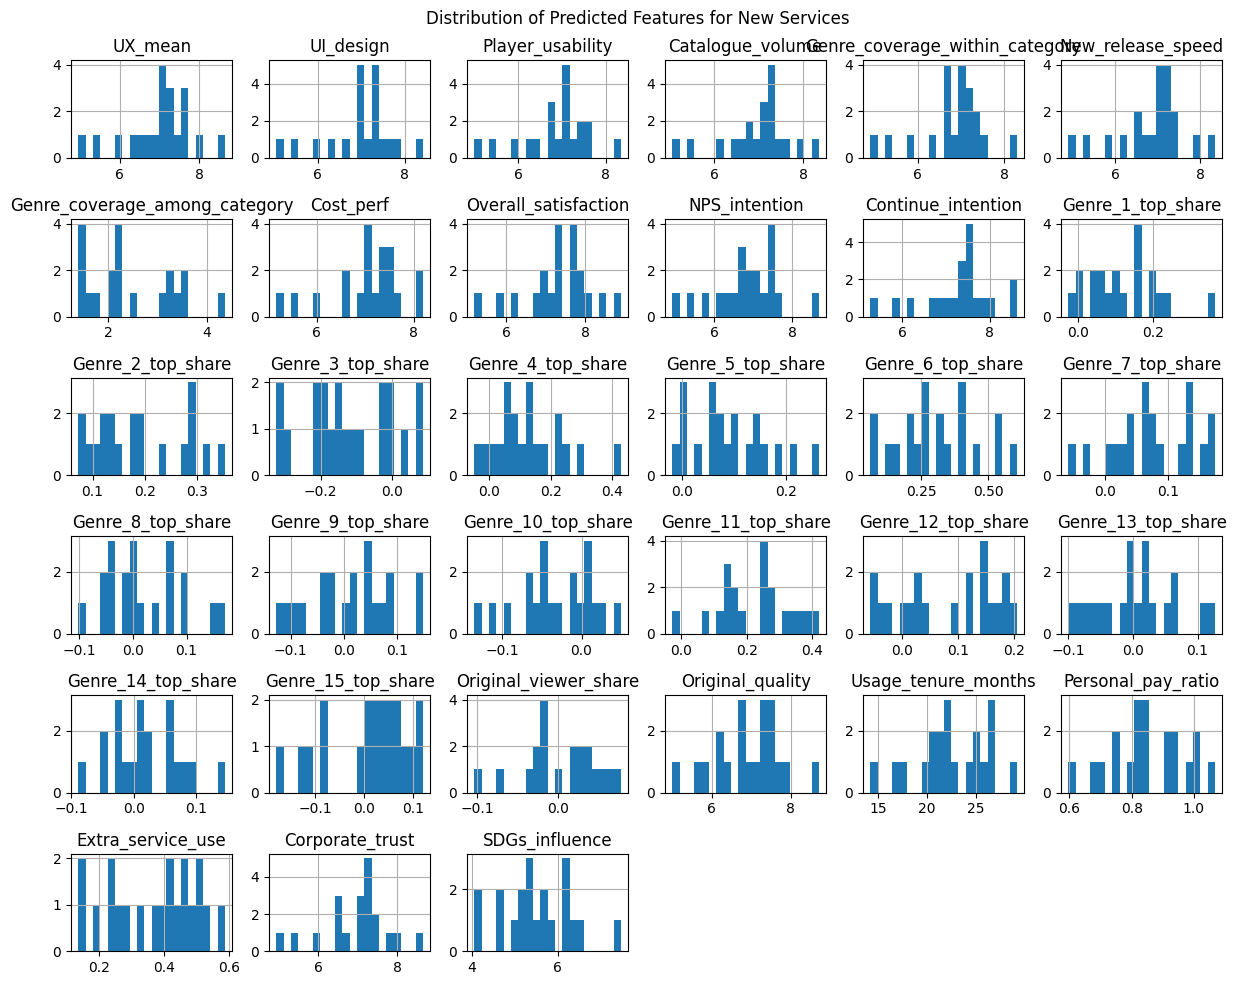

In [42]:
# 新サービスの特徴量をデータフレーム化
new_service_df = pd.DataFrame(X_new, columns=feat_df.columns)

# 各特徴量を可視化（ヒストグラムなど）
new_service_df.hist(figsize=(12, 10), bins=20)
plt.suptitle('Distribution of Predicted Features for New Services')
plt.tight_layout()
plt.show()

In [43]:
# 新サービスと元のサービスの特徴量の平均差を計算
avg_diff = np.abs(feat_df.values - X_new).mean(axis=0)

# 最も差分が大きい特徴量を表示
top_diff_indices = np.argsort(avg_diff)[::-1][:10]
print("New service's most distinctive features:")
for idx in top_diff_indices:
    print(f"{feat_df.columns[idx]}: Difference {avg_diff[idx]:.3f}")


New service's most distinctive features:
Usage_tenure_months: Difference 6.632
Genre_coverage_among_category: Difference 1.524
Genre_coverage_within_category: Difference 1.032
SDGs_influence: Difference 1.020
Overall_satisfaction: Difference 1.018
NPS_intention: Difference 0.997
Corporate_trust: Difference 0.983
New_release_speed: Difference 0.967
Catalogue_volume: Difference 0.966
Continue_intention: Difference 0.937


In [44]:
# 省略せずに全列・全行を表示する設定
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
new_service_df

,UX_mean,UI_design,Player_usability,Catalogue_volume,Genre_coverage_within_category,New_release_speed,Genre_coverage_among_category,Cost_perf,Overall_satisfaction,NPS_intention,Continue_intention,Genre_1_top_share,Genre_2_top_share,Genre_3_top_share,Genre_4_top_share,Genre_5_top_share,Genre_6_top_share,Genre_7_top_share,Genre_8_top_share,Genre_9_top_share,Genre_10_top_share,Genre_11_top_share,Genre_12_top_share,Genre_13_top_share,Genre_14_top_share,Genre_15_top_share,Original_viewer_share,Original_quality,Usage_tenure_months,Personal_pay_ratio,Extra_service_use,Corporate_trust,SDGs_influence
0,7.638293,7.489064,7.382029,7.348829,7.220789,7.267450,3.214193,7.490410,7.912097,7.543456,7.598875,0.198818,0.312834,-0.304325,0.429220,0.262932,0.165412,0.126795,0.171779,0.146247,-0.096456,0.144578,0.170466,0.048798,0.146382,0.019168,-0.103430,7.467288,24.755938,0.837214,0.527663,7.354668,6.191111
1,7.341222,7.156030,7.184092,7.107670,6.941215,7.133681,3.092119,7.174273,7.631921,7.499022,7.395153,0.233135,0.284895,-0.017284,0.125545,0.145071,0.059905,0.021661,0.065411,0.011555,0.006101,0.331904,0.144519,-0.072167,-0.048527,-0.122243,0.077469,7.388436,20.434439,0.942612,0.444008,7.265798,6.416630
2,6.979926,7.069180,6.698404,7.066962,6.617707,6.970606,2.479214,7.049649,7.336734,6.790721,7.425728,0.000373,0.076605,0.088463,0.133679,0.001587,0.258803,0.032035,-0.005563,0.091109,0.049842,0.387674,-0.047366,0.062867,0.015874,0.094511,-0.019734,7.186069,26.404587,1.003826,0.148686,7.199852,5.200933
3,7.306710,7.341566,7.086402,7.418535,7.205311,7.330300,2.199157,7.523690,7.689601,7.268063,7.712320,0.107009,0.125645,-0.010285,0.084572,0.180618,0.246404,0.039659,-0.033444,0.090957,-0.013758,0.340115,-0.041154,-0.011734,-0.088373,0.056204,0.028944,7.499572,21.382589,0.993691,0.390223,7.396945,5.872154
4,8.653533,8.418718,8.348818,8.352394,8.304242,8.352880,4.366811,8.195705,8.919476,8.696415,8.626966,0.192020,0.289694,0.030146,0.214828,0.148710,0.067098,0.084329,0.154706,0.040915,-0.027614,0.150013,0.148996,-0.064509,0.053743,-0.179669,0.031582,8.715014,25.505320,1.068233,0.588081,8.656034,7.478777
5,6.659186,6.929740,6.737949,6.777086,6.712453,6.613275,1.451089,6.873888,6.963767,6.347457,7.343612,-0.026630,0.142896,-0.190584,0.108537,-0.018042,0.453106,0.037020,-0.057761,-0.037301,-0.056992,0.244530,0.189130,0.027609,0.064078,0.061179,-0.028087,6.271178,26.471628,0.827156,0.256390,6.584067,4.618090
6,5.444048,5.522469,5.427420,5.527364,5.261173,5.323410,2.106219,5.583236,5.751158,5.437877,5.910178,0.012040,0.185783,-0.025960,-0.013272,0.034775,0.261361,0.075328,-0.035567,-0.028040,0.029190,0.284717,-0.056443,0.105451,-0.008785,0.120136,-0.014989,5.621753,20.248926,0.685759,0.136455,5.467999,4.068065
7,4.953657,5.053629,5.002522,5.066725,4.903677,4.892895,1.630037,5.161460,5.183347,4.933693,5.271608,0.075226,0.177088,-0.146173,-0.048239,0.086211,0.329134,0.133858,-0.013729,-0.126844,-0.001050,0.147399,-0.021549,0.022591,-0.018414,0.062242,-0.022520,5.007068,14.212175,0.596441,0.272456,4.945014,4.066585
8,7.553542,7.355565,7.376744,7.276980,7.237531,7.222773,3.370444,7.368382,7.817017,7.517321,7.538439,0.366703,0.269741,-0.139830,0.247224,0.101057,0.134135,0.072321,0.097209,-0.019712,0.019888,0.242555,0.190520,-0.100152,0.011185,-0.086169,0.038431,7.347326,22.177654,0.843965,0.480341,7.345744,6.499668
9,7.412313,7.317562,7.130399,7.245295,6.961974,7.263066,2.272347,7.405951,7.731377,7.185545,7.843661,0.033081,0.110236,-0.094905,0.141570,0.004938,0.316631,0.063349,0.009441,0.071165,0.011969,0.422332,0.035660,0.061742,0.080690,0.105368,-0.019542,7.527621,26.946928,1.017562,0.243249,7.368019,5.352436


In [45]:
# ── ① new15 の行を取り出す ──────────────────────────
row15 = df_result.query("service == 'new15'").iloc[0]

# ── ② 流入人数に変換（率 × 市場規模） ────────────────
#     ※ すでに run_ot_for_candidate() 内で total_market_size を掛けて
#       'total_inflow' に絶対人数が入っている場合は↓不要
inbound_users = row15["total_inflow"]                 # 人
print(f"想定流入人数: {inbound_users:,.0f} 人")

# ── ③ 単価を掛けて月次／累計売上を推計 ──────────────
monthly_fee      = 690           # 円
avg_tenure_month = 17.7          # 月
monthly_sales    = inbound_users * monthly_fee
lifetime_sales   = monthly_sales * avg_tenure_month

print(f"月次売上予測 : ¥{monthly_sales:,.0f}")
print(f"LTV 売上予測: ¥{lifetime_sales:,.0f}  (継続 {avg_tenure_month} ヵ月)")


想定流入人数: 634,749 人
月次売上予測 : ¥437,977,104
LTV 売上予測: ¥7,752,194,749  (継続 17.7 ヵ月)
